In [1]:
import pickle
import numpy as np
import pandas as pd
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, CuDNNLSTM, Dropout, Bidirectional, RepeatVector
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.regularizers import L1L2
from keras.utils import plot_model
import keras.backend as k
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

Using TensorFlow backend.
/home/kaush/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/kaush/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/kaush/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/kaush/.local/lib/python3.6/site-packages/tensorflow/python/fra

In [2]:
df = pickle.load(open('./dumps/df.pkl', 'rb'))
df.month = np.sin(2*np.pi/12*df.month)
df

,visibility,dew_pt,QFE,LC,TC,DRY,RH,WET,month
2016-01-01 05:45:00,6.0,7.4,927.0,1,1,8.7,92.0,8.0,5.000000e-01
2016-01-01 08:45:00,7.0,8.4,929.3,4,6,10.2,89.0,9.2,5.000000e-01
2016-01-01 11:45:00,9.0,7.8,930.0,2,2,17.6,54.0,12.2,5.000000e-01
2016-01-01 14:45:00,8.0,8.8,927.0,1,3,20.8,46.0,14.0,5.000000e-01
2016-01-01 17:45:00,7.0,10.3,927.3,1,2,16.4,67.0,12.9,5.000000e-01
2016-01-02 05:45:00,6.0,7.9,927.3,1,1,8.6,95.0,8.2,5.000000e-01
2016-01-02 08:45:00,7.0,8.8,929.1,1,1,10.2,91.0,9.4,5.000000e-01
2016-01-02 11:45:00,7.0,8.7,928.4,1,1,18.5,53.0,12.8,5.000000e-01
2016-01-02 14:45:00,8.0,9.8,925.7,2,2,21.6,47.0,14.5,5.000000e-01
2016-01-02 17:45:00,7.0,10.2,924.6,1,1,16.7,66.0,13.0,5.000000e-01


### The number of days to look back to make predictions

In [3]:
LOOK_BACK = 10

### Create the data for training LSTM

In [4]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), :]
        dataX.append(a)
        dataY.append(dataset[i + look_back, :])
    return np.array(dataX), np.array(dataY)

### We need to scale the data, because some columns have values that are way greater than others

In [5]:
scaler = StandardScaler()
X = scaler.fit_transform(df)

In [6]:
X, y = create_dataset(X, look_back=LOOK_BACK)
X.shape, y.shape

((5469, 10, 9), (5469, 9))

In [7]:
X_train, y_train = X[:-500], y[:-500]
X_test, y_test = X[-500:], y[-500:]

In [17]:
k.clear_session()
model = Sequential()
model.add(Dropout(0.25, input_shape=(LOOK_BACK, 9), name='Input_Layer'))
model.add(CuDNNLSTM(4*LOOK_BACK, return_sequences=True, name='LSTM_1'))
model.add(CuDNNLSTM(3*LOOK_BACK, return_sequences=True, name='LSTM_2'))
model.add(Dropout(0.25))
model.add(CuDNNLSTM(2*LOOK_BACK, return_sequences=True, name='LSTM_3'))
model.add(Dropout(0.25))
model.add(CuDNNLSTM(LOOK_BACK, return_sequences=True, name='LSTM_4'))
model.add(CuDNNLSTM(LOOK_BACK, return_sequences=False, name='LSTM_5'))
model.add(Dense(81, activation='tanh', name='FullyConnected_1'))
model.add(Dropout(0.25))
model.add(Dense(27, activation='relu', name='FullyConnected_2'))
model.add(Dropout(0.25))
model.add(Dense(9, name='Output'))
model.summary()
plot_model(model)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_Layer_input (InputLaye (None, 10, 9)             0         
_________________________________________________________________
Input_Layer (Dropout)        (None, 10, 9)             0         
_________________________________________________________________
LSTM_1 (CuDNNLSTM)           (None, 10, 40)            8160      
_________________________________________________________________
LSTM_2 (CuDNNLSTM)           (None, 10, 30)            8640      
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 30)            0         
_________________________________________________________________
LSTM_3 (CuDNNLSTM)           (None, 10, 20)            4160      
_________________________________________________________________
dropout_2 (Dropout)          (None, 10, 20)            0         
__________

In [18]:
callbacks = [
    EarlyStopping(patience=25),
    ModelCheckpoint('./dumps/best-model.h5', save_best_only=True, period=5)
]
model.compile(loss='mse', optimizer='adam')

In [19]:
model.fit(X_train, y_train, epochs=1000, batch_size=128, validation_split=0.2, shuffle=False, callbacks=callbacks)

Train on 3975 samples, validate on 994 samples
Epoch 1/1000
3975/3975 [==============================] - 2s 472us/step - loss: 0.9739 - val_loss: 0.8563
Epoch 2/1000
3975/3975 [==============================] - 0s 123us/step - loss: 0.8034 - val_loss: 0.6703
Epoch 3/1000
3975/3975 [==============================] - 1s 151us/step - loss: 0.7123 - val_loss: 0.5964
Epoch 4/1000
3975/3975 [==============================] - 1s 145us/step - loss: 0.6740 - val_loss: 0.5313
Epoch 5/1000
3975/3975 [==============================] - 1s 135us/step - loss: 0.6470 - val_loss: 0.5046
Epoch 6/1000
3975/3975 [==============================] - 1s 148us/step - loss: 0.6037 - val_loss: 0.5121
Epoch 7/1000
3975/3975 [==============================] - 1s 140us/step - loss: 0.6080 - val_loss: 0.4892
Epoch 8/1000
3975/3975 [==============================] - 1s 143us/step - loss: 0.5822 - val_loss: 0.4892
Epoch 9/1000
3975/3975 [==============================] - 1s 130us/step - loss: 0.5864 - val_loss: 0.5175

3975/3975 [==============================] - 1s 131us/step - loss: 0.4210 - val_loss: 0.3732
Epoch 78/1000
3975/3975 [==============================] - 1s 126us/step - loss: 0.4043 - val_loss: 0.3673
Epoch 79/1000
3975/3975 [==============================] - 1s 128us/step - loss: 0.4138 - val_loss: 0.3644
Epoch 80/1000
3975/3975 [==============================] - 1s 130us/step - loss: 0.4146 - val_loss: 0.3551
Epoch 81/1000
3975/3975 [==============================] - 0s 126us/step - loss: 0.3937 - val_loss: 0.3652
Epoch 82/1000
3975/3975 [==============================] - 0s 122us/step - loss: 0.4049 - val_loss: 0.3799
Epoch 83/1000
3975/3975 [==============================] - 0s 125us/step - loss: 0.4010 - val_loss: 0.3781
Epoch 84/1000
3975/3975 [==============================] - 1s 130us/step - loss: 0.3948 - val_loss: 0.3678
Epoch 85/1000
3975/3975 [==============================] - 1s 127us/step - loss: 0.3943 - val_loss: 0.3531
Epoch 86/1000
3975/3975 [==========================

3975/3975 [==============================] - 1s 127us/step - loss: 0.3447 - val_loss: 0.2935
Epoch 154/1000
3975/3975 [==============================] - 0s 123us/step - loss: 0.3472 - val_loss: 0.2985
Epoch 155/1000
3975/3975 [==============================] - 0s 124us/step - loss: 0.3480 - val_loss: 0.3069
Epoch 156/1000
3975/3975 [==============================] - 0s 126us/step - loss: 0.3503 - val_loss: 0.3219
Epoch 157/1000
3975/3975 [==============================] - 1s 130us/step - loss: 0.3558 - val_loss: 0.3069
Epoch 158/1000
3975/3975 [==============================] - 1s 137us/step - loss: 0.3533 - val_loss: 0.2969
Epoch 159/1000
3975/3975 [==============================] - 0s 124us/step - loss: 0.3504 - val_loss: 0.3035
Epoch 160/1000
3975/3975 [==============================] - 1s 130us/step - loss: 0.3624 - val_loss: 0.3064
Epoch 161/1000
3975/3975 [==============================] - 1s 129us/step - loss: 0.3636 - val_loss: 0.3226
Epoch 162/1000
3975/3975 [=================

Epoch 229/1000
3975/3975 [==============================] - 1s 136us/step - loss: 0.3362 - val_loss: 0.2709
Epoch 230/1000
3975/3975 [==============================] - 0s 125us/step - loss: 0.3348 - val_loss: 0.2780
Epoch 231/1000
3975/3975 [==============================] - 1s 127us/step - loss: 0.3369 - val_loss: 0.3044
Epoch 232/1000
3975/3975 [==============================] - 0s 124us/step - loss: 0.3459 - val_loss: 0.3115
Epoch 233/1000
3975/3975 [==============================] - 1s 133us/step - loss: 0.3444 - val_loss: 0.2838
Epoch 234/1000
3975/3975 [==============================] - 0s 124us/step - loss: 0.3250 - val_loss: 0.2724
Epoch 235/1000
3975/3975 [==============================] - 1s 127us/step - loss: 0.3254 - val_loss: 0.2750
Epoch 236/1000
3975/3975 [==============================] - 1s 127us/step - loss: 0.3242 - val_loss: 0.2714
Epoch 237/1000
3975/3975 [==============================] - 1s 129us/step - loss: 0.3301 - val_loss: 0.2706
Epoch 238/1000
3975/3975 [==

### Save the model

In [21]:
model.save('./dumps/best-model.h5')

In [23]:
pickle.dump(model.history, open('./dumps/history.pkl', 'wb'))

### Load the model, if it has been previously trained

In [24]:
model = load_model('./dumps/best-model.h5')
history = pickle.load(open('./dumps/history.pkl', 'rb'))

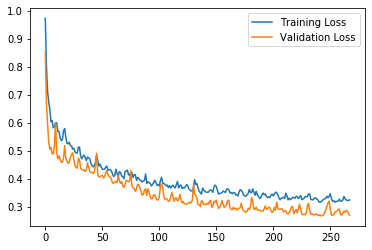

In [26]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend()

# The model has been trained, get predictions for the test set

### Predicted values

In [27]:
preds = model.predict(X_test)
predictions = pd.DataFrame(scaler.inverse_transform(preds), columns=df.columns, index=df.tail(len(X_test)).index)
predictions = predictions.drop('month', axis=1)
predictions.index = pd.MultiIndex.from_arrays([predictions.index.date, predictions.index.time], names=['Date','Time'])
predictions = predictions.unstack().reset_index().set_index('Date')
for col in predictions:
    predictions[col] = predictions[col].map('{:,.1f}'.format).astype(float)
predictions

visibility                                       dew_pt           \
Time         05:45:00 08:45:00 11:45:00 14:45:00 17:45:00 05:45:00 08:45:00   
Date                                                                          
2018-09-23        7.6      6.4      7.2      9.1      9.5     21.3     19.1   
2018-09-24        8.1      5.8      7.1      8.6      9.2     21.0     19.5   
2018-09-25        7.4      5.4      5.9      7.4      8.2     21.9     20.6   
2018-09-26        6.4      4.9      6.0      7.4      8.1     21.7     21.0   
2018-09-27        6.7      5.2      5.8      8.2      8.6     22.0     21.3   
...               ...      ...      ...      ...      ...      ...      ...   
2018-12-27        8.3      6.7      6.7      9.0      9.7     11.5      9.2   
2018-12-28        8.1      7.1      7.5      9.1      9.5     11.1      8.6   
2018-12-29        8.0      6.9      7.4     10.0     10.3     10.8      8.5   
2018-12-30        9.9      7.5      8.0     10.6     10.7      9.2      7.8   
2018-12-31       10.4      7.8      8.3     10.7     10.8      9.1      7.4   

                                       ...       RH                    \
Time       11:45:00 14:45:00 17:45:00  ... 05:45:00 08:45:00 11:45:00   
Date                                   ...                              
2018-09-23     19.4     20.1     20.9  ...     77.7     85.6     80.4   
2018-09-24     20.2     21.3     21.7  ...     75.2     90.7     81.9   
2018-09-25     20.9     21.4     22.0  ...     80.6     93.4     89.6   
2018-09-26     21.0     22.2     23.0  ...     85.3     93.6     87.8   
2018-09-27     21.0     21.9     22.9  ...     84.6     92.3     89.3   
...             ...      ...      ...  ...      ...      ...      ...   
2018-12-27      9.5      9.7      9.6  ...     71.2     92.2     89.8   
2018-12-28      8.6      9.4      9.6  ...     68.0     91.9     89.5   
2018-12-29      8.3      8.6      8.8  ...     67.0     91.8     89.3   
2018-12-30      7.5      8.6      8.8  ...     57.8     91.3     89.0   
2018-12-31      7.6      8.8      9.0  ...     59.9     90.0     87.6   

                                  WET                                      
Time       14:45:00 17:45:00 05:45:00 08:45:00 11:45:00 14:45:00 17:45:00  
Date                                                                       
2018-09-23     68.9     67.0     22.7     19.9     20.6     22.2     23.1  
2018-09-24     72.5     69.2     22.5     20.0     21.2     23.0     23.7  
2018-09-25     79.6     75.0     23.0     20.9     21.4     22.6     23.5  
2018-09-26     79.9     76.2     22.5     21.3     21.7     23.3     24.3  
2018-09-27     74.6     73.2     22.8     21.6     21.6     23.4     24.4  
...             ...      ...      ...      ...      ...      ...      ...  
2018-12-27     60.8     54.7     13.9      9.8     10.3     13.2     13.8  
2018-12-28     63.9     55.8     13.9      9.2      9.4     12.6     13.7  
2018-12-29     57.3     53.4     13.6      9.1      9.2     12.5     13.1  
2018-12-30     56.7     53.1     13.1      8.5      8.4     12.6     13.2  
2018-12-31     55.3     52.4     12.8      8.2      8.6     13.0     13.4  

[100 rows x 40 columns]

### Actual Values

In [28]:
actual = df.tail(len(X_test))
actual.index = pd.MultiIndex.from_arrays([actual.index.date, actual.index.time], names=['Date','Time'])
actual = actual.drop('month', axis=1)
actual = actual.unstack().reset_index().set_index('Date')
actual

visibility                                       dew_pt           \
Time         05:45:00 08:45:00 11:45:00 14:45:00 17:45:00 05:45:00 08:45:00   
Date                                                                          
2018-09-23        6.0      8.0     10.0     10.0      8.0     20.1     21.2   
2018-09-24        5.0      6.0     10.0     10.0      5.0     20.7     20.3   
2018-09-25        2.0      5.0      7.0      8.0      7.0     21.8     22.1   
2018-09-26        3.0      3.0      6.0      9.0      9.0     20.5     22.2   
2018-09-27        6.0      6.0      6.0     10.0     10.0     20.0     20.8   
...               ...      ...      ...      ...      ...      ...      ...   
2018-12-27        7.0     10.0     10.0     10.0     10.0      7.2      7.0   
2018-12-28        6.0      7.0      8.0     10.0     10.0      5.3      6.8   
2018-12-29        6.0     10.0     10.0     10.0     10.0      4.1      5.7   
2018-12-30        7.0     10.0     10.0     10.0     10.0      4.4      5.6   
2018-12-31        7.0     10.0     10.0     10.0     10.0      4.6      5.4   

                                       ...       RH                    \
Time       11:45:00 14:45:00 17:45:00  ... 05:45:00 08:45:00 11:45:00   
Date                                   ...                              
2018-09-23     22.0     22.3     22.0  ...     97.0     82.0     70.0   
2018-09-24     23.5     22.4     21.8  ...     89.0     78.0     70.0   
2018-09-25     22.8     23.0     23.0  ...     96.0     90.0     70.0   
2018-09-26     22.0     22.4     22.7  ...     90.0     91.0     75.0   
2018-09-27     22.5     22.0     21.9  ...     90.0     82.0     75.0   
...             ...      ...      ...  ...      ...      ...      ...   
2018-12-27      6.6      7.2      6.3  ...     94.0     88.0     53.0   
2018-12-28      7.3      6.8      8.6  ...     92.0     90.0     61.0   
2018-12-29      6.5      6.6      8.7  ...     89.0     86.0     55.0   
2018-12-30      6.6      6.4      9.3  ...     94.0     89.0     54.0   
2018-12-31      6.5      7.2      7.8  ...     95.0     84.0     53.0   

                                  WET                                      
Time       14:45:00 17:45:00 05:45:00 08:45:00 11:45:00 14:45:00 17:45:00  
Date                                                                       
2018-09-23     64.0     73.0     20.2     22.2     23.8     24.5     23.5  
2018-09-24     72.0     90.0     21.3     21.5     25.2     24.0     22.4  
2018-09-25     69.0     81.0     22.0     22.7     24.6     24.7     24.0  
2018-09-26     63.0     72.0     21.0     22.7     23.4     24.6     24.2  
2018-09-27     61.0     73.0     20.6     21.8     23.8     24.3     23.4  
...             ...      ...      ...      ...      ...      ...      ...  
2018-12-27     48.0     60.0      7.7      8.0     11.2     12.4      9.8  
2018-12-28     50.0     70.0      6.0      7.6     10.8     12.0     11.3  
2018-12-29     45.0     68.0      5.4      6.8     11.0     12.3     11.4  
2018-12-30     40.0     67.0      4.8      6.6     11.2     12.8     12.1  
2018-12-31     42.0     60.0      5.0      6.7     11.2     13.2     11.4  

[100 rows x 40 columns]

# Visualize the predictions

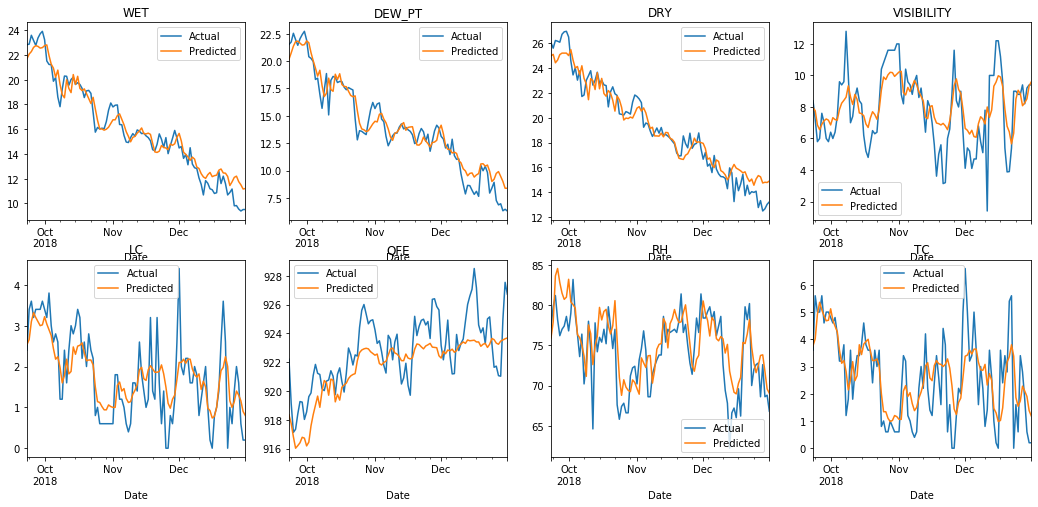

In [29]:
columns = list(set(actual.columns.get_level_values(0)))
columns
fig, ax_array = plt.subplots(2, 4, figsize=(18, 8))
for i in range(2):
    for j in range(4):
        title = columns[4*i+j]
        ax = actual[(title,)].mean(axis=1).plot(kind='line', ax=ax_array[i][j], title=title.upper())
        ax = predictions[(title,)].mean(axis=1).plot(kind='line', ax=ax_array[i][j], title=title.upper())
        ax.legend(['Actual', 'Predicted'])